---
title: Voice Emotion Classification
author: Catie Baxter and Otis Milliken 
date: '2024-04-07'
description: "Final Project for CS0451"
format: html
---

Here is a link to the [dataset](https://zenodo.org/records/1188976#.XrC7a5NKjOR) with used.

The files in our dataset were named using a specific naming structure by the original authors. Each file has a unique filename that act as identifiers for the characteristics of the audio file.

There are 7 digits, divided by dashes (e.g. "02-01-06-01-02-01-12.mp4"). 

The first digit reflects the **modality**:

    01 - full-AV

    02 - video only

    03 - audio-only
    

The second digit is the vocal channel. We are only investigating the speech files so they will all be 01.

The third digit is the **emotion** which will be our target variable.

    01 - neutral

    02 - calm

    03 - happy

    04 - sad

    05 - angry

    06 - fearful
    
    07 - disgust

    08 - surprised

The fourth digit reflects the emotional intensity, which is 01 for normal and 02 for strong.

The fifth digit reflects the **statement** in the file:

    01 - "Kids are talking by the door"
    
    02 - "Dogs are sitting by the door"

The sixth digit indicates the repetition number of the study: 01 or 02.

Finally the seventh digit is the actor that spoke in the recording, labelled 01 to 24. Odd numbers are male and even numbers are female. 


In [2]:
import os
import pandas as pd
import librosa
import numpy as np
import torch


In [3]:

# assign directory

directory = "data"

dictionary = {
    'Filepath': [],
    'Modality': [],
    'Vocal_channel': [],
    'Emotion':[],
    'Emotional_intensity':[],
    'Statement':[],
    'Repetition':[],
    'Actor':[],
    'Sample':[],
    'Sample_rate': [],
    'Sex':[],
    'Mel_sgram': []
}

def parse_filename(file):
    filename = file[5:-4]
    digits = filename.split("-")
    dictionary['Modality'].append(digits[0])
    dictionary['Vocal_channel'].append(digits[1])
    dictionary['Emotion'].append(int(digits[2])-1)
    dictionary['Emotional_intensity'].append(digits[3])
    dictionary['Statement'].append(digits[4])
    dictionary['Repetition'].append(digits[5])
    dictionary['Actor'].append(digits[6])
    dictionary['Sex'].append('Female' if (int(digits[6]) % 2) == 0 else 'Male') # odd numbers are male (1), even numbers female (0)
    return 

def create_sgram(sample, sr):
    sgram = librosa.stft(sample)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=0)
    return mel_sgram

def getting_files(directory):
    for filename in os.listdir(directory):
        file = os.path.join(directory, filename) 
        if os.path.isfile(file):
            dictionary['Filepath'].append(file)
            samples, samplerate = librosa.load(file)
            dictionary['Sample'].append(samples)
            dictionary['Sample_rate'].append(samplerate)
            dictionary['Mel_sgram'].append(create_sgram(samples, samplerate))
            parse_filename(file)

getting_files(directory)


In [4]:
from random import randint
def findMaxSize(df):
    max_row = -1
    max_column = -1
    for i, sgram in enumerate(df):
        max_column = max(sgram.shape[0], max_column)
        max_row = max(sgram.shape[1], max_row)
    return max_column, max_row

def padding_mel(sgrams, max_row, max_column):
    for i, sgram in enumerate(sgrams):
        length = max_column - len(sgram[0])
        beg_pad = randint(0, length)
        end_pad = length - beg_pad
        sgram = np.pad(sgram, ((0, 0), (0, end_pad)), mode='constant')
        sgram = np.pad(sgram, ((0, 0), (beg_pad, 0)), mode='constant')
        sgrams[i] = sgram
    return

max_row, max_column = findMaxSize(dictionary["Mel_sgram"])
padding_mel(dictionary["Mel_sgram"], max_row, max_column)
df = pd.DataFrame(dictionary)

In [5]:
print(df['Mel_sgram'][2])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Split up our Data

In the next step we split up our data

In [6]:
from sklearn.model_selection import train_test_split

data = df[["Mel_sgram", "Emotion"]]

df_train, df_test = train_test_split(data, test_size = 0.3, random_state = 123)

In [7]:
X_train = df_train["Mel_sgram"]
y_train = df_train["Emotion"]

X_test = df_test["Mel_sgram"]
y_test = df_test["Emotion"]

X_train.head()

585     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1419    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
417     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
317     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1067    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: Mel_sgram, dtype: object

In [8]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.head()

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: Mel_sgram, dtype: object

In [9]:
SAMPLE_RATE = df["Sample_rate"][0]

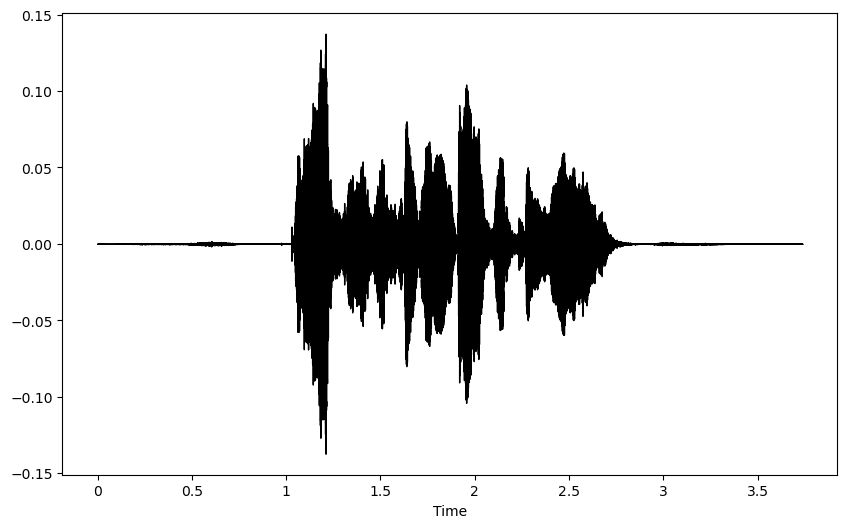

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
librosa.display.waveshow(df["Sample"][0], sr=SAMPLE_RATE, color="black")

## Creating Mel Spectogram

In [11]:
#librosa.display.specshow(X_train[0], sr=SAMPLE_RATE, x_axis='time', y_axis='mel')
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


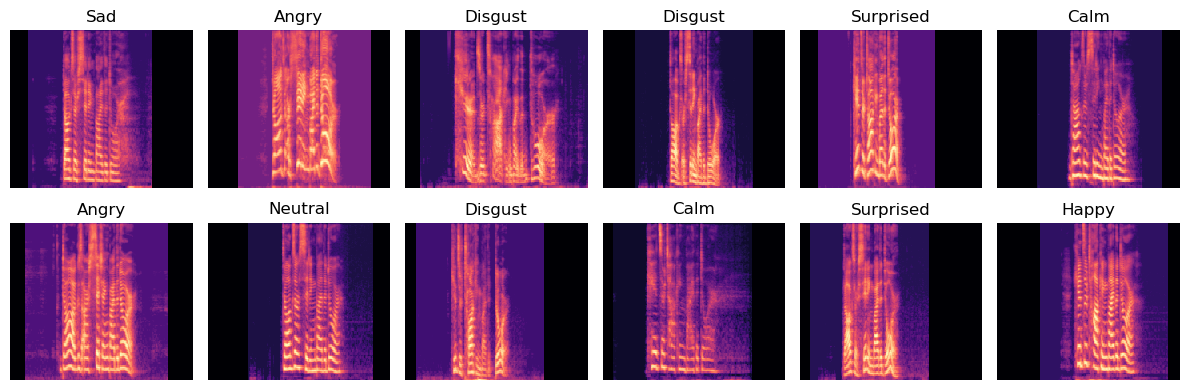

In [12]:
from matplotlib import pyplot as plt
EMOTIONS = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

def show_images(X, y, rows, cols):
    fig, axarr = plt.subplots(rows, cols, figsize = (2*cols, 2*rows))
    for i, ax in enumerate(axarr.ravel()):
        librosa.display.specshow(X[i], sr=SAMPLE_RATE, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title = f"{EMOTIONS[y[i]]}")
        ax.axis("off")
    plt.tight_layout()

show_images(X_train, y_train, 2, 6)

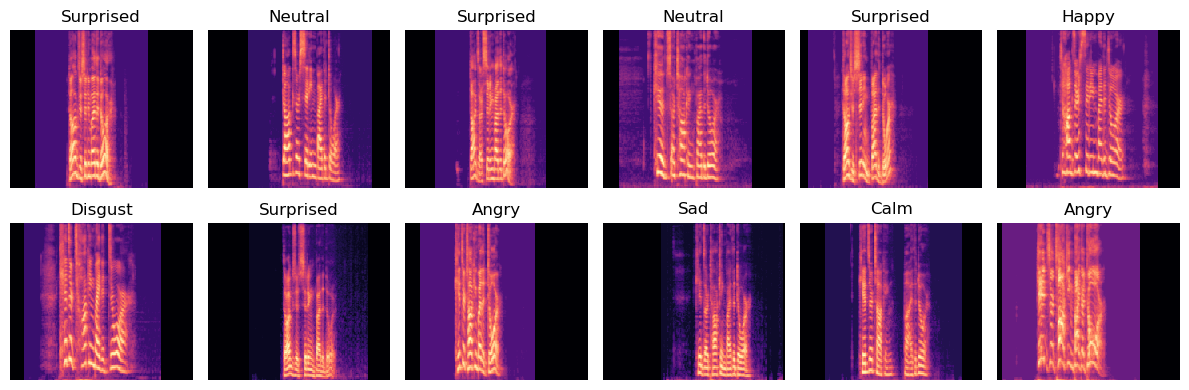

In [13]:
show_images(X_test, y_test, 2, 6)

In [14]:
print(X_train.shape)

def prep(df_X, df_y):
    y = torch.tensor(df_y.values)
    X = torch.tensor(df_X)
    print(X.shape)
    X = X.unsqueeze(1)
    return X, y

X_train_rs, y_train_rs = prep(X_train, y_train)
X_test_rs, y_test_rs = prep(X_test, y_test)

print(X_train_rs.shape)


(1008,)


/var/folders/jl/09jgt7dd3sz8vwxd15c41dp80000gn/T/ipykernel_76598/3593060238.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/torch/csrc/utils/tensor_new.cpp:264.)
  X = torch.tensor(df_X)


torch.Size([1008, 128, 228])
torch.Size([432, 128, 228])
torch.Size([1008, 1, 128, 228])


In [15]:

data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_rs, y_train_rs),
    batch_size = 128,
    shuffle = True
)

data_loader_test = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test_rs, y_test_rs),
    batch_size = 128,
    shuffle = True
)

In [16]:
## Convolutional Models
torch.manual_seed(12)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

X_train_rs, y_train_rs = X_train_rs.to(device), y_train_rs.to(device)
X_test_rs, y_test_rs = X_test_rs.to(device), y_test_rs.to(device)


import torch.nn as nn
from torch.nn import ReLU

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.pipeline = torch.nn.Sequential(
            # 128 x 228
            nn.Conv2d(1, 32, 3),
            ReLU(),
            # nn.Conv2d(16, 32, 3),
            # ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3),
            ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(52800, 812),
            nn.Linear(812, 8)
        )

    def forward(self, x):
        return self.pipeline(x)
    
model = ConvNet().to(device)


Running on cpu.


In [17]:
from sklearn.metrics import confusion_matrix
import numpy as np

def evaluate(model):


    # count the number of total observations and correct predictions
    total_train = 0
    total_correct_test = 0
    total_test = 0
    total_correct_train = 0


    y_pred_total = []
    y_total = []
    cf_matrix = np.zeros((8, 8))

    for X_train, y_train in data_loader_train:

        # move the data to the device (ideally, to gpu)
        X_train, y_train = X_train.to(device), y_train.to(device)

        # compute the predictions
        scores = model.forward(X_train)
        y_pred_train =  torch.argmax(scores, dim = 1)
        
        # update the total and the number of correct predictions
        total_train += X_train.size(0)
        total_correct_train += (y_pred_train == y_train).sum().item()

    # loop through the data loader
    for X, y in data_loader_test:

        # move the data to the device (ideally, to gpu)
        X, y = X.to(device), y.to(device)

        # compute the predictions
        scores = model.forward(X)
        y_pred = torch.argmax(scores, dim = 1)
        
        # update the total and the number of correct predictions
        total_test += X.size(0)
        total_correct_test += (y_pred == y).sum().item()

        y_pred_total.append(y_pred.item)
        y_total.append(y.item)


        # pred_np = np.unique(y_pred.numpy())
        # print(pred_np)

        # if len(pred_np) == 8:
        #     print('here')
        cf = confusion_matrix(y, y_pred)

        if cf.shape == (8,8):
            cf_matrix += cf
    #cf_matrix = confusion_matrix(y_total, y_pred_total)
    print(f"training accuracy = {total_correct_train / total_train:.3f}")
    print(f"validation accuracy = {total_correct_test / total_test:.3f}")
    return cf_matrix

    

In [18]:
import torch.optim as optim


def train(model, k_epochs = 1, evaluate_after_epoch = True, **opt_kwargs):
    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.SGD(model.parameters(), **opt_kwargs)

    for epoch in range(k_epochs):
        for i, data in enumerate(data_loader_train):
            X, y = data
            X, y = X.to(device), y.to(device)

            # clear accumulated gradients
            optimizer.zero_grad()

    
            # compute the loss
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            loss.backward()
            optimizer.step()

        if evaluate_after_epoch:
            print(f"Epoch {epoch}: ", end = "")
            cf = evaluate(model)

    return cf

    

In [19]:
cf = train(model, k_epochs = 5,  lr = 0.0001, evaluate_after_epoch = True, momentum = 0.9)

Epoch 0: training accuracy = 0.147
validation accuracy = 0.116
Epoch 1: training accuracy = 0.173
validation accuracy = 0.139
Epoch 2: training accuracy = 0.191
validation accuracy = 0.139
Epoch 3: training accuracy = 0.205
validation accuracy = 0.134
Epoch 4: training accuracy = 0.219
validation accuracy = 0.130


In [20]:
cf.shape

(8, 8)

           Neutral  Calm  Happy   Sad  Angry  Fearful  Disgust  Surprised
Neutral        0.0   4.0    2.0  16.0    0.0      0.0      1.0        0.0
Calm           0.0   9.0    3.0  18.0    0.0      1.0      6.0        0.0
Happy          0.0  12.0    6.0  24.0    2.0      2.0      9.0        0.0
Sad            0.0  13.0    5.0  14.0    0.0      2.0     10.0        1.0
Angry          0.0   6.0    9.0  27.0    7.0      4.0      9.0        0.0
Fearful        0.0   8.0    2.0  23.0    4.0      2.0     11.0        0.0
Disgust        0.0  14.0    9.0  21.0    1.0      0.0     10.0        0.0
Surprised      0.0  12.0    8.0  27.0    3.0      0.0      7.0        0.0


<Axes: >

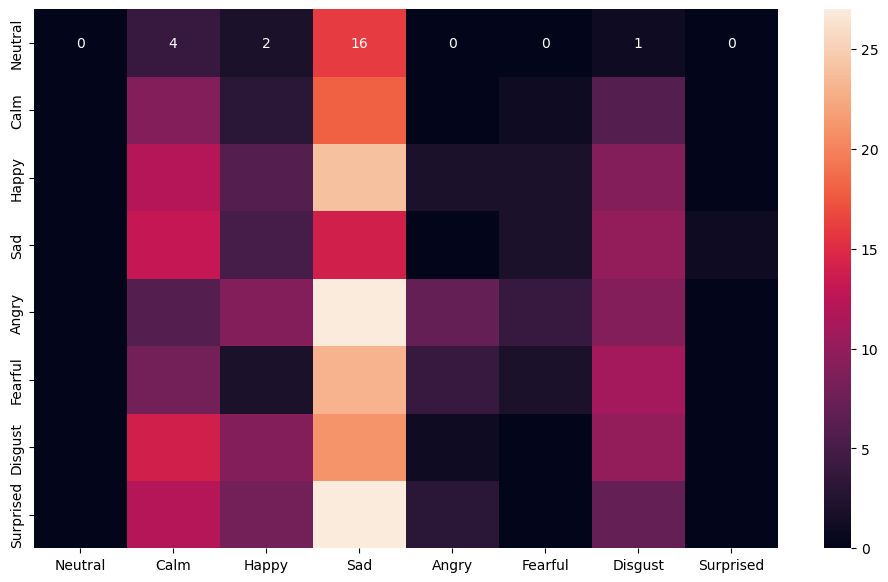

In [21]:
EMOTIONS = ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cf , index = [i for i in EMOTIONS],
                     columns = [i for i in EMOTIONS])

plt.figure(figsize = (12,7))

print(df_cm)
sn.heatmap(df_cm, annot=True)


In [22]:
most_common_value = y_test.mode()[0]  
percentage = (y_test.value_counts()[most_common_value] / len(y_test)) * 100
print(f"Most Common Emotion: {EMOTIONS[most_common_value]}, percentage: {percentage}")

# if we want to visualize all of the emotion percentages
# for i in range(0, 8):
#     percentage = (y_test.value_counts()[i] / len(y_test)) * 100
#     print(i, percentage)


Most Common Emotion: Angry, percentage: 15.046296296296296


In [23]:
evaluate(model)

training accuracy = 0.219
validation accuracy = 0.130


array([[ 0.,  4.,  2., 16.,  0.,  0.,  1.,  0.],
       [ 0.,  9.,  5., 23.,  0.,  1.,  7.,  0.],
       [ 0., 12.,  8., 27.,  2.,  2.,  9.,  0.],
       [ 0., 16.,  7., 18.,  0.,  3., 10.,  1.],
       [ 0.,  7.,  9., 28.,  7.,  5.,  9.,  0.],
       [ 0.,  8.,  3., 26.,  5.,  3., 12.,  0.],
       [ 0., 17., 12., 24.,  1.,  0., 11.,  0.],
       [ 0., 13.,  9., 28.,  3.,  0.,  9.,  0.]])